# **Lab 10**: April 17, 2019.
## Topic: Goldreich-Goldwasser-Halevi (GGH) Algorithm

Main concept: To see how the closest vector problem is used in public key cryptography 

In [19]:
#These are some imports that we will use later. Below are functions that you may find useful during the lab. Remember to run this cell.
from sage.all import *

def plot_2d_lattice(v1, v2, xmin=-10, xmax=10, ymin=-10, ymax=10, show_basis_vectors=True):
    """
    plot_2d_lattice will return a sage plot of a lattice with v1 and v2 as basis vectors.
    (x|y)(min|max) define the maximum and minimum x and y coordinates for the lattice points
    on the plot. if show_basis_vectors is false, the basis vectors will not be shown on the
    plot.
    """
    pts = []
    # plot all integer multiples of the basis so long as the x and y coordinates
    # are within (x|y)(min|max).
    for i in range(xmin, xmax):
        for j in range(ymin, ymax):
            pt = i*v1 + j*v2
            x,y = pt[0], pt[1]
            if x < xmin or x > xmax or y < ymin or y > ymax:
                continue
            pts.append(pt)
    the_plot = plot(points(pts))
    if show_basis_vectors:
        the_plot += plot(v1) + plot(v2)
    return the_plot

def hadamard_ratio(basis):
    """
    hadamard_ratio returns the hadamard ratio of the supplied basis. the hadamard
    ratio is a number between 0 and 1 that quantifies the orthogonality of the
    baiss. The higher the hadamard ratio, the more orthogonal (read: better) the
    basis.
    """
    if len(basis.rows()) != len(basis.columns()):
        raise Exception("no non-square matrices allowed")
    BR = basis.change_ring(RR)
    d = BR.determinant()
    ls = [v.norm() for v in BR]
    l = reduce(lambda x,y: 1.0*x*y, ls)
    return (d/l)**(1.0/3.0)

def generate(n, d=10, high_ratio_req=.97, low_ratio_req=.1):
        # generate random matrices until we have a matrix that is invertible
        # and has a high enough hadamard ratio.
        while True:
            try:
                V = random_matrix(ZZ, n, x=-d, y=d)
                V.inverse()
                if hadamard_ratio(V) < high_ratio_req:
                    # hadamard ratio was too low. try again.
                    continue 
            except ZeroDivisionError:
                # non-invertible matrix. try again.
                pass
            else:
                break

        # multiple the public matrix by randomly generated unimodular matrices
        # until the hadamard ratio reaches a certain "badness" threshold (i.e.
        # a low enough hadamard ratio)
        W = V
        while hadamard_ratio(W) > low_ratio_req:
            U = random_matrix(ZZ, n, upper_bound=d, algorithm='unimodular')
            W = U*W
        # return an array with the private key first then the public key
        return [V,W]

In [3]:
generate(2)

[
[ 5 -3]  [  53  189]
[ 3  3], [ -75 -267]
]

### Part 0: Vectors and matrices in Sage

In this lab you will have to work with vectors and matrices and do calculations with them. This can certainly be done on pen and paper, but you can also do the operations in Sage.

You can work with integral vectors in Sage using the command $\texttt{vector(ZZ,[a,b])}$. For example, the vector $\texttt{v1 = (1,4)}$) can be saved in Sage with the code $\texttt{v1 = vector(ZZ, [1,4])}$). 

**Exercise 0.1**: Write two vectors in Sage and label them $v1$ and $v2$.

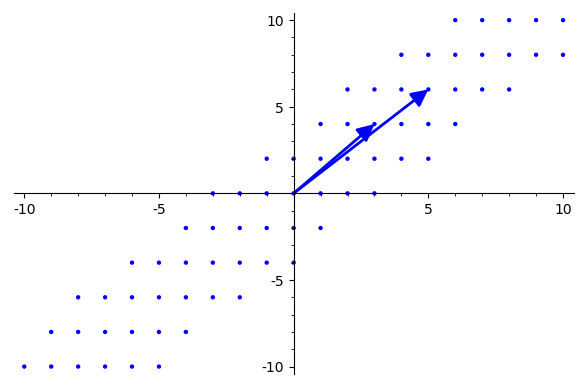

In [20]:
show(plot_2d_lattice(vector(ZZ,[5,6]),vector(ZZ,[3,4])))

**Exercise 0.2**: Use Sage to find $v1 + v2$. Verify your answer.

If you have two vectors you can look at the lattice spanned by them using the code $\texttt{show(plot_2d_lattice(v1,v2))}$.

**Exercise 0.3**: Display the lattice spanned by $v1$ and $v2$. Is $v1+v2$ in the lattice?

Mathematically, we treat a basis for a lattice as a matrix. To form a matrix from two vectors $v1$ and $v2$ in Sage use the command $\texttt{matrix(ZZ,[v1,v2])}$. To form a matrix 
$\bigl(\begin{smallmatrix}
a&b \\ c&d
\end{smallmatrix} \bigr)$ in Sage use the command $\texttt{matrix(ZZ,[[a, b],[c,d]])}$.

**Exercise 0.4**: Using Sage store the matrix formed by $v1$ and $v2$ in $M$.

It will be important to find inverse matrices for this lab. The inverse matrix to $M$, called $M^{-1}$, is the matrix such that $M\cdot M^{-1} = \bigl(\begin{smallmatrix}
1&0 \\ 0&1
\end{smallmatrix} \bigr)$. To find the inverse of a matrix do $\texttt{M.inverse()}$.

**Exercise 0.5**: Use Sage to find the inverse matrix, $M_inv$, to the $M$ you formed in **Exercise 0.4**. Verify it is the inverse by computing $\texttt{M*M_inv}$. 

##### CHECK IN: Once you and your team have done the exercises above, call me over. #####

### Part 1: The basic idea

On Monday we learned the basics of lattice methods and about the closest vector problem. Today we will work with a public key encryption scheme based on the ideas of the closest vector problem.

**Question 1.1**: Reflecting on our conversation from Monday, what are qualities of a 'good' basis? What are qualities of a 'bad' basis?

With those definitions in mind, the main idea for GGH is as follows:
- Choose an $n$-dimensional lattice $L \subset \mathbb{Z}^n$ (picture an $n \times n$ grid filled with equally spaced points).
- Let $B$ be a 'good' basis for the lattice.
- Create $B'$, which is a 'bad' basis for the lattice. This basis becomes public.
- To encrypt a message $m \in \mathbb{Z}^n$ we compute the ciphertext $c = m \cdot B' + e$, where $e$ is a random short vector.
- To decrypt a ciphertext $c \in \mathbb{R}^n$ we use the good basis $B$ to find the lattice point $m\cdot B'$, and from there we can find $m$. 

**Question 1.2**: How is the closest vector problem used in this outline of the cryptosystem?

**Exercise 1.3**: Choose two vectors that form a 'good' basis and display the lattice spanned by them.

**Exercise 1.4**: Choose two vectors that form a 'bad' basis and display the lattice spanned by them.

##### CHECK IN: Once you and your team have discussed the questions above, call me over. #####

### Part 2: Setting up a GGH cryptosystem

We will do this in dimension 2 so that it is easier to visualize. However, in practice GGH is done in dimension $n \geq 200$.

To get keys we will use a function called $\texttt{generate()}$. This function creates a 'good' basis, $B$, for your private key and a 'bad' basis, $B'$, as your public key. The bases are actually linked with a matrix $U$, in fact, $$U \cdot B = B'.$$ This fact will be important later.

**Exercise 2.1**: Use the $\texttt{generate(n)}$ function to get private and public keys, where $n$ is the dimension. For this case we want $n=2$. The function will output an array of arrays where the first array forms the basis for your private key and the second array forms the basis for your public key.

*Note: If you are having trouble understanding the output of $\texttt{generate(n)}$ please call me over!*

**Exercise 2.2**: Store your private key as $\texttt{B_priv}$ and store your public key as $\texttt{B_pub}$.

**Exercise 2.3**: Display your public key using $\texttt{show(plot_2d_lattice(v1,v2))}$.

**Exercise 2.4**: Display your private key using $\texttt{show(plot_2d_lattice(v1,v2))}$.

**Exercise 2.5**: Make your bad basis public by writing it on your team's whiteboard. 

### Part 3: Encryption

Send a message to one of your teammates.

**Exercise 3.1**: Choose a message $m$. Here $m$ should be a small $2$-dimensional vector (ex. $m=(3,2)$). In practice, as the dimension grows $m$ is allowed to be a larger vector (hence to have a large message space be secure the dimension should be large as well).

**Exercise 3.2**: The first step of encryption is to multiply $m$ by your teammate's public key $B'$. Let $a = m\cdot B'$.

**Exercise 3.3**: To encode $m$, you will need to make a random short vector $e$ which will provide 'noise' to the vector $a$. The entries of $e$ should belong to $\{\sigma, -\sigma\}$ for some natural number $\sigma$. For our purposes $e$ is a 2-dimensional vector and we let $\sigma \leq 2$.

*Note: you may use $\texttt{randint}$ to create $e$ or you may just pick the componenets for $e$.*

**Exercise 3.4**: Finally, to make the ciphertext, $c$, compute $c = a + e$. 

**Question 3.5**: What makes decoding $c$ difficult? How is the intended recipient able to do it?

### Part 4: Decryption

Once you receive a message from your teammate, it is time to decrypt! This means solving the closest vector problem.

**Exercise 4.1**: The first step in decryption is to find the inverse matrix to your private key $B$. To do that, we have to save $B$ as a matrix in Sage and then use the $\texttt{inverse}$ command.

*Note: if $B = [[2,3],[1,5]]$ then to save it as a matrix you would write $\texttt{B = matrix(ZZ, [[2,3],[1,5]])}$. Then to find the inverse simply do $\texttt{B.inverse()}$.*

**Exercise 4.2**: Verify that what you got in **Exercise 4.1** is in fact the inverse to $B$.

**Exercise 4.3**: Compute $c \cdot B^{-1}$. 

**Exercise 4.4**: Now you want to get rid of the 'error'. To do this, round the entries in $c \cdot B^{-1}$ to their closest integer value. Once you do this rounding, the vector you have is actually $m\cdot U$, where $U$ is the matrix such that $U\cdot B = B'$.

**Exercise 4.5**: Lastly we want a way to remove $U$. To find $U^{-1}$, we compute $B\cdot B'^{-1}$.

**Exercise 4.6**: Finally, multiply $U^{-1}$ by your answer to **Exercise 4.4**.

**Exercise 4.7**: Verify with your neighbor that you decrypted their message correctly! If you didn't decrypt it correctly, try choosing a different close integer vector in **Exercise 4.4**.

### Part 5: What just happened??

Here we dissect the algorithm a bit to get a better idea of how it works. This part should involve no numbers and just letters, in an effort to understand the basics of the algorithm.

**Exercise 5.1**: Write $c$ in terms of $U, B, m,$ and $e$.

**Question 5.2**: What happens when you multiply $c\cdot B^{-1}$? Simplify the answer.

**Question 5.3**: With your answer to **Exercise 5.2** in mind, what are you doing in **Exercise 4.4** when rounding?

**Question 5.4**: Finally, why does multiplying by $U^{-1}$ give you a correct final answer?